In [8]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re

import random
import pickle,pprint

%matplotlib inline

In [9]:
# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [10]:
U_t=15    # mV
D=2       # mV
C=1       # 10Hz-> 0.01ms^{-1}
dt=1      #  ms
tau=20    #  ms


In [11]:
def mu(t):
    return 16


## Density equation 

$ \frac{\partial}{\partial t}q(r,t)=-\frac{\partial}{\partial r}q(r,t)-\rho(t|t-r)q(r,t)+\delta(r)A(t)$

In [12]:
t_window=100
N=int(t_window/dt)
N_sim=int(200/dt)

u_old=np.zeros((N+1,1))
u_new=np.zeros((N+1,1))

q_old=np.zeros((N+1,1))
q_old[0]=1

q=np.zeros((N+1,int(N_sim/10)))

A=np.zeros((N_sim,1))

q_new=np.zeros((N+1,1))

i_store=0

for it in range(N_sim):
    
    t=it*dt
   
    A[it]=q_new[0]/dt
    q_new = np.zeros((N + 1, 1))
    u_new = np.zeros((N + 1, 1))

    for ir in range(N):
        u_new[ir+1 ] = u_old[ir] * (1 - dt / tau) + mu(t) * dt / tau

        rho = C * np.exp((u_old[ir] - U_t) / D)

        q_new[ir + 1] = q_old[ir] * (1 - dt * rho)
        q_new[0] += dt * rho * q_old[ir]

    u_new[N] = u_old[N] * (1 - dt / tau) + mu(t) * dt / tau
    rho = C * np.exp((u_old[N] - U_t) / D)
    q_new[N] += q_old[N] * (1 - dt * rho)
    q_new[0] += dt * rho * q_old[N]


    q_old = q_new
    u_old = u_new
    
    
    if it%10==0:
        q[:,i_store]=q_new.flatten()
        i_store+=1
        

(0, 100)

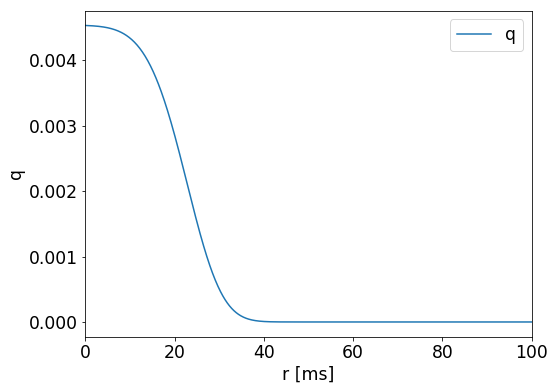

In [45]:
time=-1
t_q=[j*dt for j in range(N+1)]
plt.figure(figsize=(8,6))
plt.plot(t_q, q[:,time],label='q')
plt.xlabel('r [ms]')
plt.ylabel('q')
plt.legend()
plt.xlim(0,t_window)


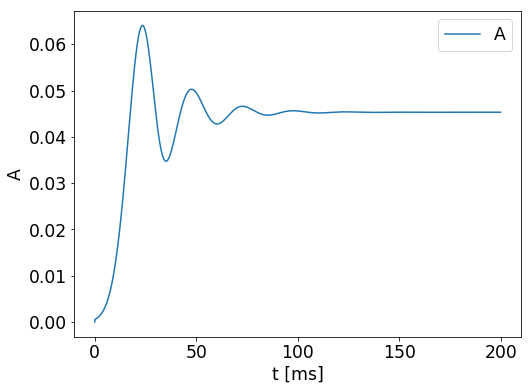

In [46]:
t_A=[(j)*dt for j in range(N_sim)]
plt.figure(figsize=(8,6))
plt.plot(t_A,A,label='A')
plt.xlabel('t [ms]')
plt.ylabel('A')
plt.legend()

In [47]:
density = {'D': D,
            'C': C,
              'dt': dt,
              'N_sim': N_sim,
              'tau':tau,
              'U_t': U_t,
              'A':A,
              't_A':t_A,
              'q':q,
              't_q':t_q,
              'mu_':16
              }

output = open('from_density_equation.pkl', 'wb')


pickle.dump(density , output)


output.close()

## Starting from the differential equation $Lq=\lambda q$

In [9]:
t_window=200
dt=0.1
N=int(t_window/dt)

ur=np.zeros((N+1,1))
rho=np.zeros((N,1))

mu_=16
for r in range(N):
    ur[r+1] = ur[r] * (1 - dt / tau)   + mu_*dt / tau
    rho[r] = C * np.exp((ur[r] - U_t) / D)

Matrix  form of the operator L

In [10]:
L=np.zeros((N+1,N+1))
for i in range(N-1):
    L[0,i+1]=rho[i]*dt
    L[i+1,i+1]=-1-rho[i]*dt
    L[i+2,i+1]=1
    
L[0,0]=-1
L[1,0]=1
L[0,N]=1
L[N,N]=-1

analatical solution q steady state i.e $\lambda=0$

In [11]:
q_ss=np.zeros((N+1,1))
q_ss[N]=1
q_ss[N-1]=1

for i in range(N-1):
    n=N-2-i
    q_ss[n]=q_ss[n+1]*(1+rho[n]*dt)

In [12]:
q_ss=q_ss/np.sum(q_ss)

In [13]:
x=np.dot(L,q_ss)
np.max(x)

4.7704895589362195e-18

(0, 100)

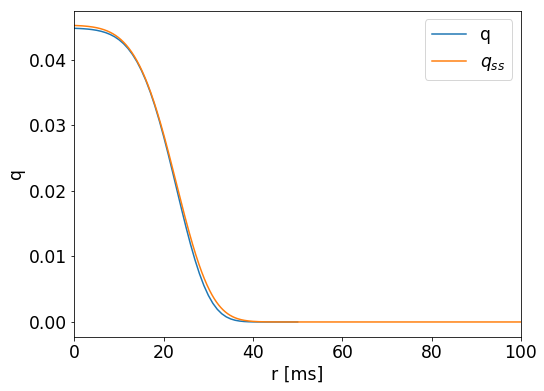

In [14]:
pkl_file = open('from_density_equation.pkl', 'rb')
density = pickle.load(pkl_file)
pkl_file.close()
q=density['q']
t_q=density['t_q']

time=-1
t_ss=[j*dt for j in range(N+1)]
plt.figure(figsize=(8,6))
plt.plot(t_q, q[:,-1],label='q')
plt.plot(t_ss,q_ss/dt,label='$q_{ss}$')
plt.xlabel('r [ms]')
plt.ylabel('q')
plt.legend()
plt.xlim(0,100)


## Increase the window time

In [ ]:

window_list=[100,200,500,1000,2000]

window_eig=np.zeros((len(window_list),4))
dt=1

for idx_w, t_window in enumerate(window_list):
    print('window:',t_window)

    N=int(t_window/dt)

    ur=np.zeros((N+1,1))
    rho=np.zeros((N,1))

    mu_=16
    for r in range(N):
        ur[r+1] = ur[r] * (1 - dt / tau)   + mu_*dt / tau
        rho[r] = C * np.exp((ur[r] - U_t) / D)
    L=np.zeros((N+1,N+1))
    for i in range(N-1):
        L[0,i+1]=rho[i]*dt
        L[i+1,i+1]=-1-rho[i]*dt
        L[i+2,i+1]=1
        
    L[0,0]=-1
    L[1,0]=1
    L[0,N]=1
    L[N,N]=-1
    
    eigv, v = np.linalg.eig(L)
    
    plt.figure(figsize=(8,8))
    plt.subplot(211)
    plt.title('eigenvalues in the complex plane for $\mu=16mV$ and $t_{window}=$'+str(t_window))
    plt.scatter(eigv.real,eigv.imag,s=2)
    #plt.subplot(212)
    #plt.scatter(eigv.real,eigv.imag,s=2)
    #plt.xlim(-0.2,0.01)
    
    real_eigv=eigv.real
    
    x=np.sort(real_eigv)
    
    eig_0=np.where(eigv.real==x[-1])
    v_0=v[:,eig_0[0][0]]
    
    t_=[j*dt for j in range(N+1)]

    
    plt.figure(figsize=(8,8))
    if v_0.real[0]>0:
        plt.plot(t_,v_0.real)
    else:
        plt.plot(t_,-1*v_0.real)
    plt.xlim(0,100)
    plt.xlabel('r [ms]')
    plt.ylabel('$q_0$')
    plt.title('$t_{window}=$'+str(t_window))
    
    
    window_eig[idx_w,0]=x[-1]
    window_eig[idx_w,1]=x[-2]
    window_eig[idx_w,2]=x[-4]
    window_eig[idx_w,3]=x[0]


window: 100
window: 200
window: 500
window: 1000
window: 2000


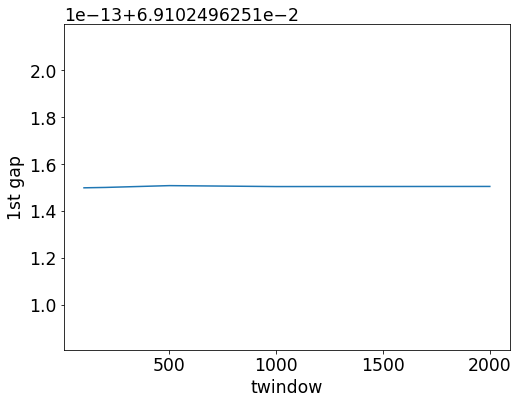

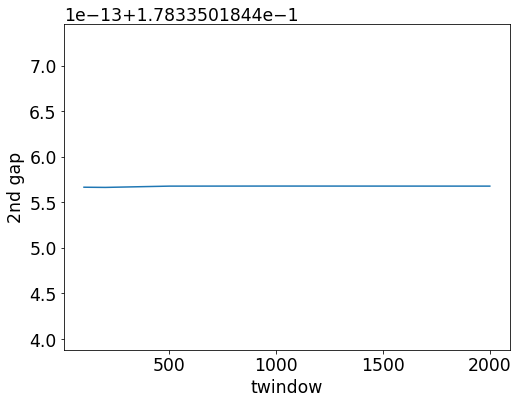

In [25]:

plt.figure(figsize=(8,6))
plt.plot( window_list, window_eig[:,0]- window_eig[:,1])
plt.xlabel('twindow')
plt.ylabel('1st gap')


plt.figure(figsize=(8,6))
plt.plot( window_list, window_eig[:,0]- window_eig[:,2])
plt.xlabel('twindow')
plt.ylabel('2nd gap')

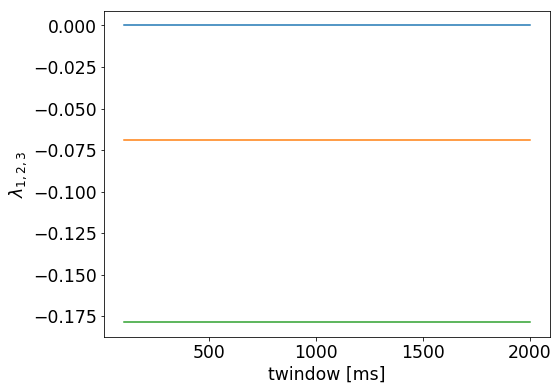

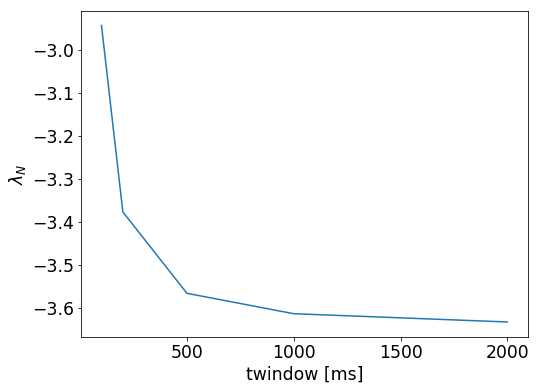

In [26]:
plt.figure(figsize=(8,6))
plt.plot( window_list, window_eig[:,0])
plt.plot( window_list, window_eig[:,1])
plt.plot( window_list, window_eig[:,2])
plt.xlabel('twindow [ms]')
plt.ylabel('$\lambda_{1,2,3}$')


plt.figure(figsize=(8,6))
plt.plot(window_list, window_eig[:,3])
plt.xlabel('twindow [ms]')
plt.ylabel('$\lambda_{N}$')

## dt convergence

dt= 5
dt= 2
dt= 1
dt= 0.5
dt= 0.1
dt= 0.05
dt= 0.02


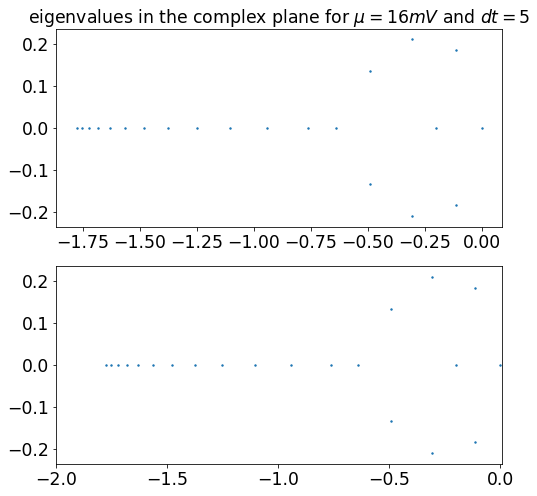

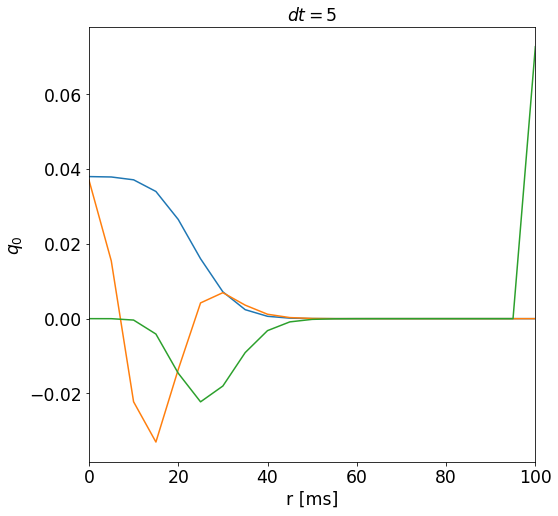

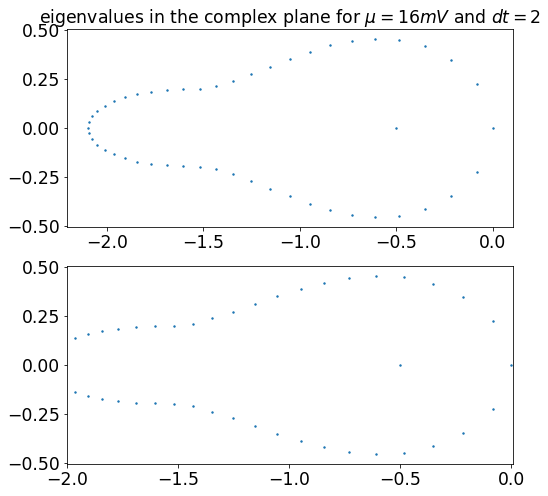

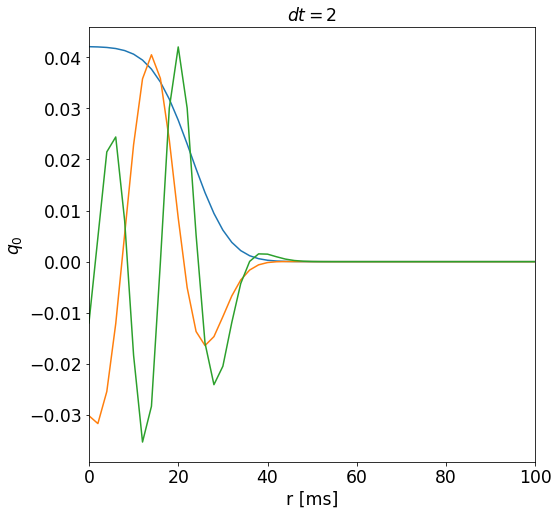

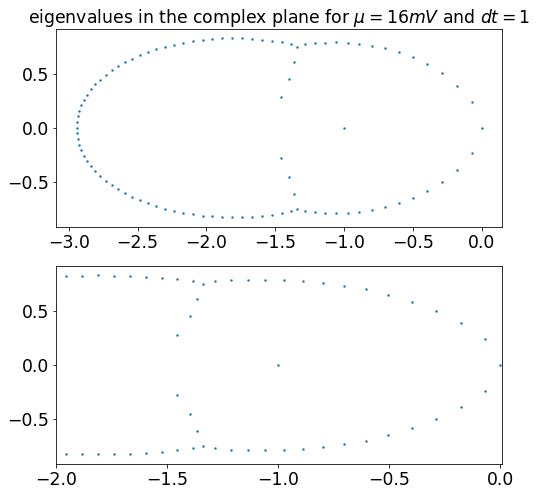

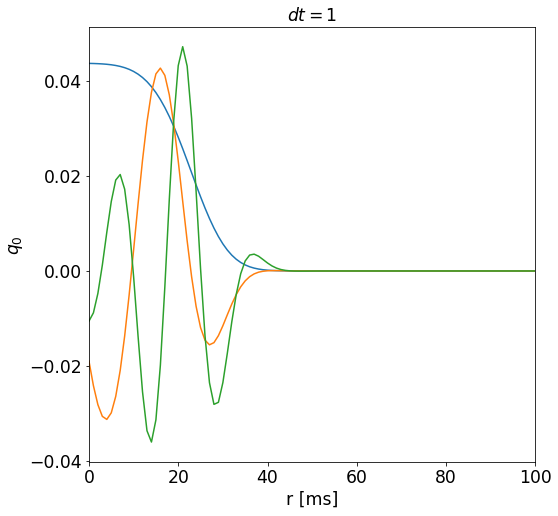

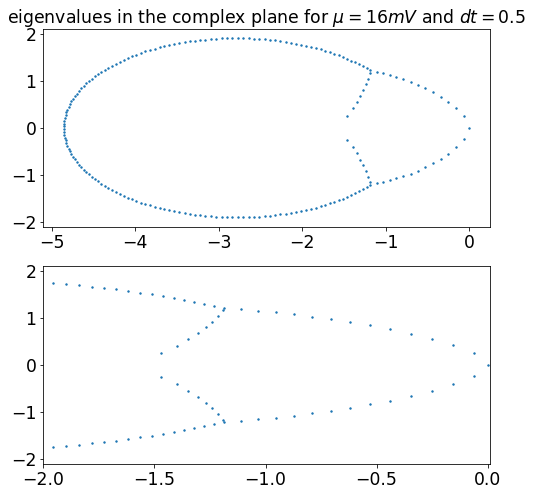

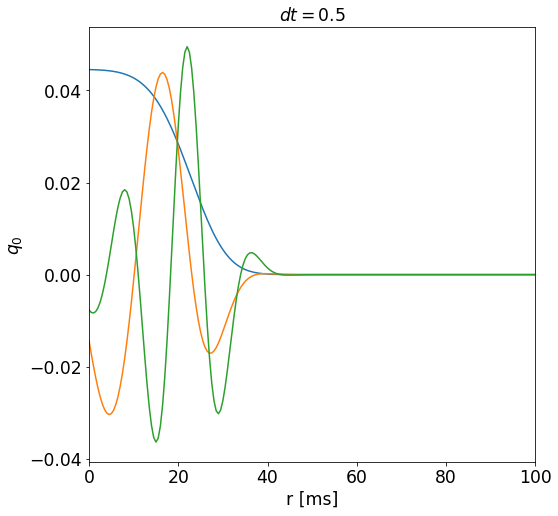

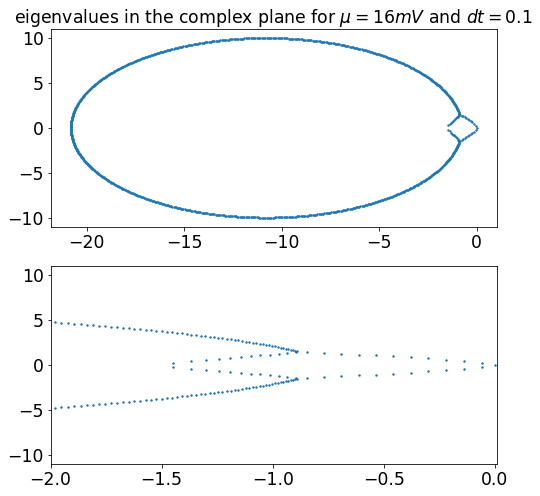

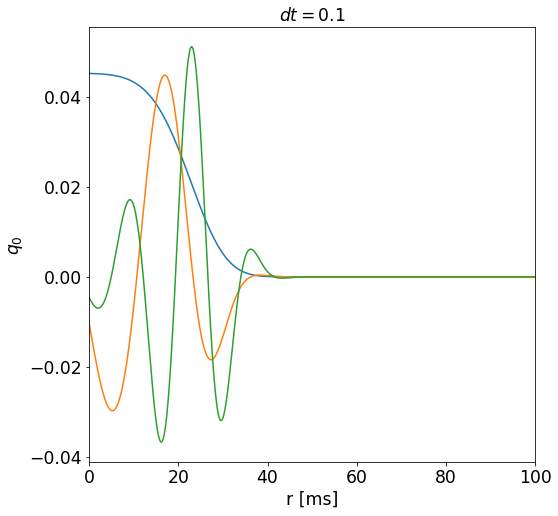

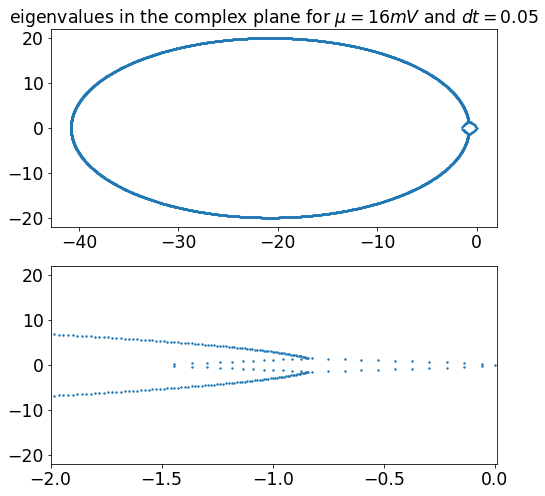

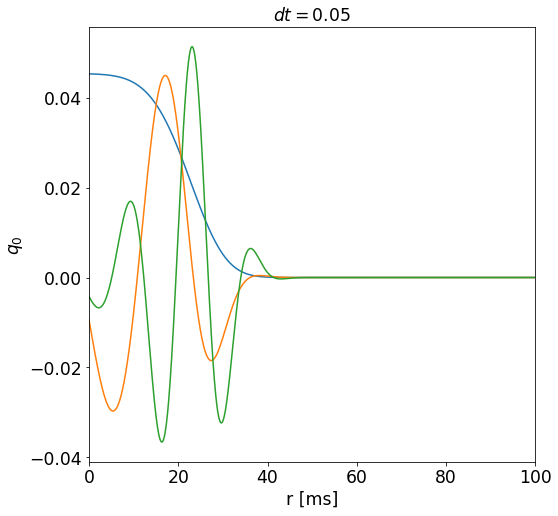

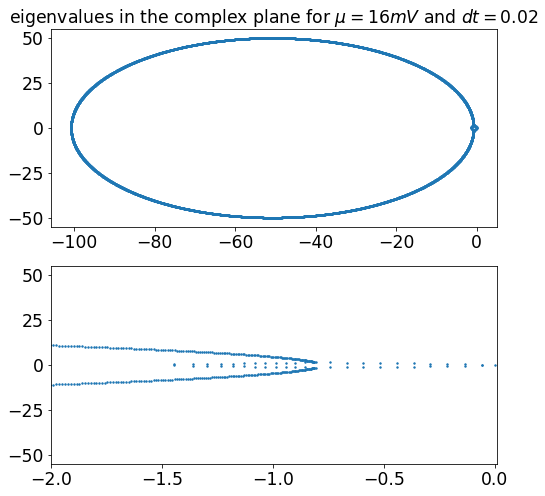

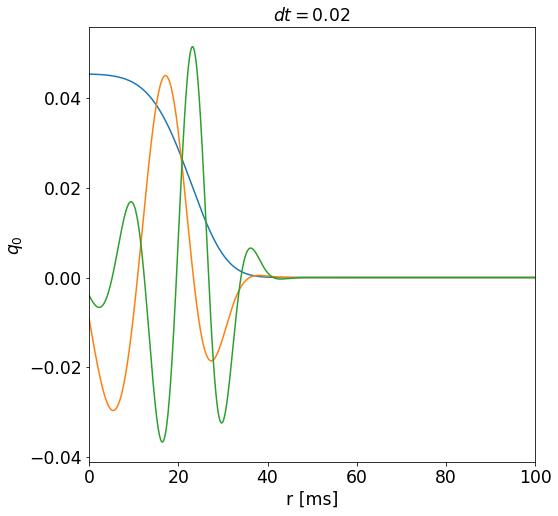

In [118]:
t_window=100

dt_list=[5,2, 1, 0.5,0.1,0.05,0.02]
v_0_list=[]
v_1_list=[]
v_2_list=[]
t_list=[]
eig_list=[]

dt_eig=np.zeros((len(dt_list),4))

for idx_dt, dt in enumerate(dt_list):
    print('dt=',dt)

    N=int(t_window/dt)

    ur=np.zeros((N+1,1))
    rho=np.zeros((N,1))

    mu_=16
    for r in range(N):
        ur[r+1] = ur[r] * (1 - dt / tau)   + mu_*dt / tau
        rho[r] = C * np.exp((ur[r] - U_t) / D)
    L=np.zeros((N+1,N+1))
    for i in range(N-1):
        L[0,i+1]=rho[i]*dt
        L[i+1,i+1]=-1-rho[i]*dt
        L[i+2,i+1]=1
        
    L[0,0]=-1
    L[1,0]=1
    L[0,N]=1
    L[N,N]=-1L
    
    eigv, v = np.linalg.eig(L)
    
    eigv=eigv/dt
    
    eig_list.append(eigv)
    
    real_eigv=eigv.real
    
    x=np.sort(real_eigv)
    
    
    dt_eig[idx_dt,0]=x[-1]
    dt_eig[idx_dt,1]=x[-2]
    dt_eig[idx_dt,2]=x[-4]
    dt_eig[idx_dt,3]=x[0]
    
    plt.figure(figsize=(8,8))
    plt.subplot(211)
    plt.title('eigenvalues in the complex plane for $\mu=16mV$ and $dt=$'+str(dt))
    plt.scatter(eigv.real,eigv.imag,s=2)
    plt.subplot(212)
    plt.scatter(eigv.real,eigv.imag,s=2)
    plt.xlim(-2,0.01)
    
    
    eig_0=np.where(eigv.real==x[-1])
    v_0=v[:,eig_0[0][0]].real
    
    if v_0[0]<0:
        v_0=-1*v_0
    
        
    
    eig_1=np.where(eigv.real==x[-2])
    v_1=v[:,eig_1[0][0]].real
    
    if np.max(v_1)!=np.max(abs(v_1)):
        v_1=-1*v_1
        
    
    eig_2=np.where(eigv.real==x[-4])
    v_2=v[:,eig_2[0][0]].real
    
    if np.max(v_2)!=np.max(abs(v_2)):
        v_2=-1*v_2
    
    t_=[j*dt for j in range(N+1)]
    t_list.append(t_)

    
    plt.figure(figsize=(8,8))
   
    norm=np.sum(v_0)*dt
    plt.plot(t_,v_0/norm,label='$v_0$')
    plt.plot(t_,v_1/norm,label='$v_1$')
    plt.plot(t_,v_2/norm,label='$v_2$')
    
    
    v_0_list.append(v_0/norm)
    v_1_list.append(v_1/norm)
    v_2_list.append(v_2/norm)
    
    plt.xlim(0,100)
    plt.xlabel('r [ms]')
    plt.ylabel('$q_0$')
    plt.title('$dt=$'+str(dt))


In [120]:
spectrum = {'eig_list': eig_list,
            'dt_list':dt_list
           }


output = open('sepctrum_varying_dt.pkl', 'wb')

pickle.dump(spectrum , output)

output.close()

In [5]:
pkl_file = open('sepctrum_varying_dt.pkl', 'rb')

spectrum = pickle.load(pkl_file)
#pprint.pprint(data1)

pkl_file.close()

eig_list=spectrum['eig_list']
dt_list=spectrum['dt_list']

(-3, 3)

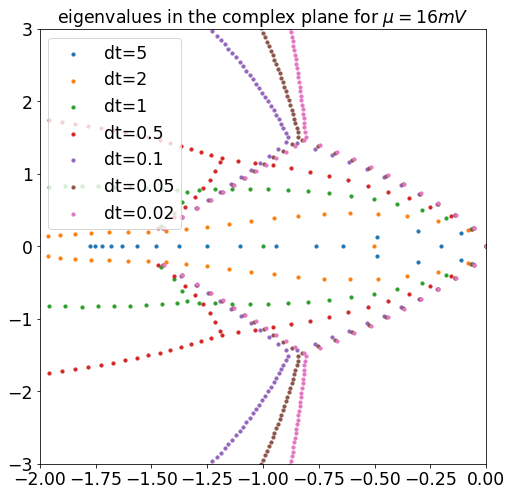

In [29]:
plt.figure(figsize=(8,8))
plt.title('eigenvalues in the complex plane for $\mu=16mV$')
for i,dt in enumerate(dt_list):
    eigv=eig_list[i]
    plt.scatter(eigv.real,eigv.imag,s=10,label='dt='+str(dt))
plt.legend()
plt.xlim(-2,0)
plt.ylim(-3,3)

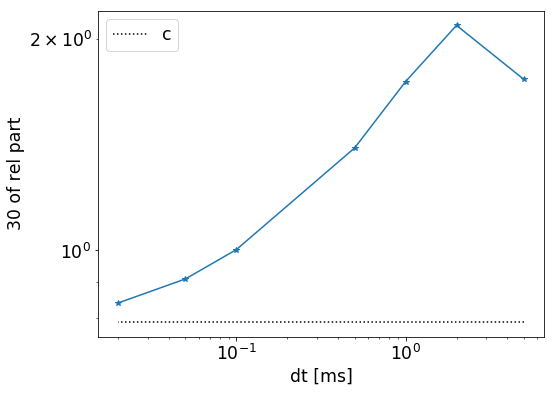

In [48]:


max_im=[]
for i,dt in enumerate(dt_list):
    eigv=eig_list[i]
    eigv=np.sort(eigv)
    idx=-50
    if len(eigv)<30:
        idx=-20
    max_im.append(abs(eigv.real)[idx])
    
plt.figure(figsize=(8,6))
#plt.semilogx( dt_list, max_im,marker='*')
plt.loglog( dt_list, [0.790581162325 for dti in dt_list],ls=':',label='c',c='k')
plt.loglog( dt_list, max_im,marker='*')
plt.legend()

plt.xlabel('dt [ms]')
plt.ylabel('30 of rel part')

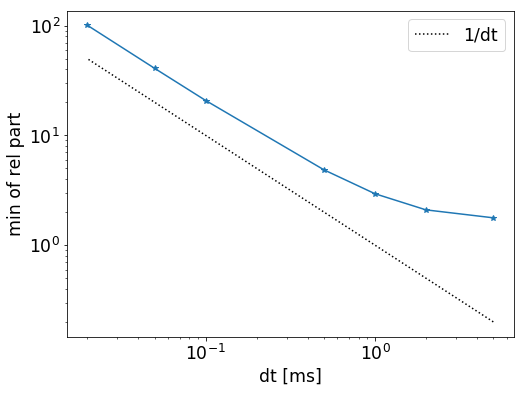

In [13]:
max_im=[]
for i,dt in enumerate(dt_list):
    eigv=eig_list[i]
    max_im.append(np.max(abs(eigv.real)))
    
plt.figure(figsize=(8,6))
#plt.semilogx( dt_list, max_im,marker='*')
plt.loglog( dt_list, [1/dti for dti in dt_list],ls=':',label='1/dt',c='k')
plt.loglog( dt_list, max_im,marker='*')
plt.legend()

plt.xlabel('dt [ms]')
plt.ylabel('min of rel part')

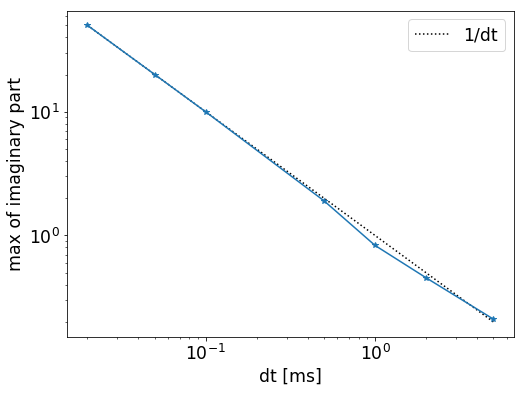

In [30]:
max_im=[]
for i,dt in enumerate(dt_list):
    eigv=eig_list[i]
    max_im.append(np.max(eigv.imag))
    
plt.figure(figsize=(8,6))
#plt.semilogx( dt_list, max_im,marker='*')
plt.loglog( dt_list, [1/dti for dti in dt_list],ls=':',label='1/dt',c='k')
plt.loglog( dt_list, max_im,marker='*')
plt.legend()

plt.xlabel('dt [ms]')
plt.ylabel('max of imaginary part')

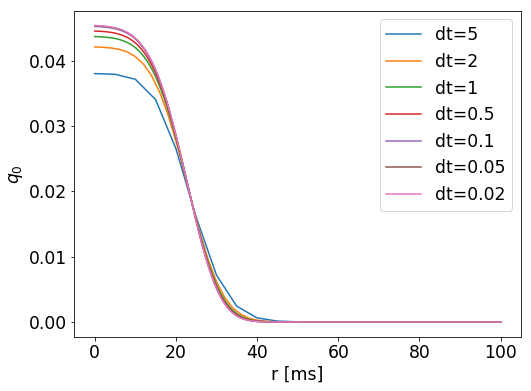

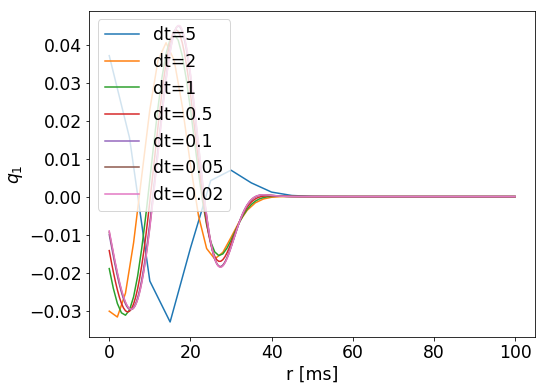

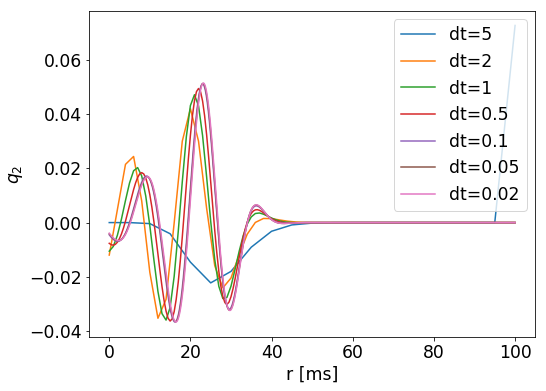

In [8]:
plt.figure(figsize=(8,6))
for i,dt in enumerate(dt_list):
    plt.plot( t_list[i], v_0_list[i],label='dt='+str(dt))
    plt.xlabel('r [ms]')
    plt.ylabel('$q_0$')
    plt.legend()


plt.figure(figsize=(8,6))
for i,dt in enumerate(dt_list):
    plt.plot( t_list[i], v_1_list[i],label='dt='+str(dt))
    plt.xlabel('r [ms]')
    plt.ylabel('$q_1$')
    plt.legend()

plt.figure(figsize=(8,6))
for i,dt in enumerate(dt_list):
    plt.plot( t_list[i], v_2_list[i],label='dt='+str(dt))
    plt.xlabel('r [ms]')
    plt.ylabel('$q_2$')
    plt.legend()



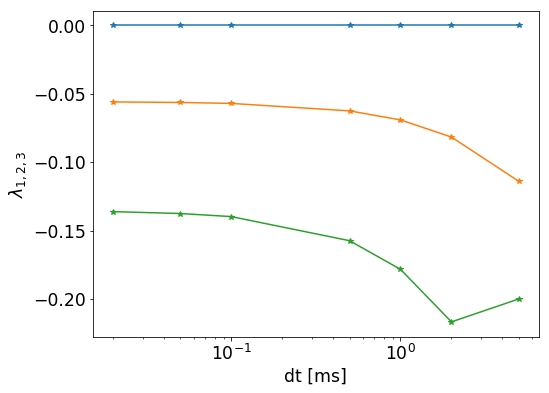

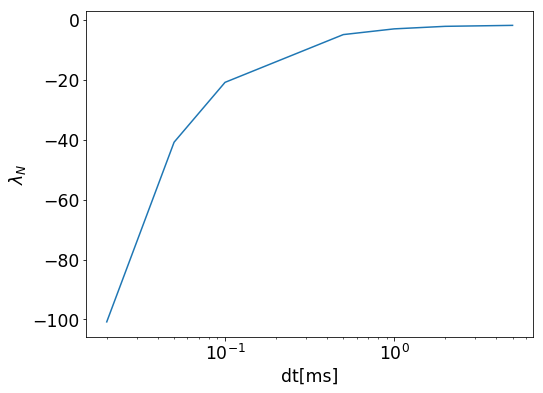

In [9]:
plt.figure(figsize=(8,6))
plt.semilogx( dt_list, dt_eig[:,0],marker='*')
plt.semilogx( dt_list, dt_eig[:,1],marker='*')
plt.semilogx( dt_list, dt_eig[:,2],marker='*')
plt.xlabel('dt [ms]')
plt.ylabel('$\lambda_{1,2,3}$')

plt.figure(figsize=(8,6))
plt.semilogx(dt_list, dt_eig[:,3])
plt.xlabel('dt[ms]')
plt.ylabel('$\lambda_{N}$')

In [116]:
rho[-1]

array([ 1.56272772])

## Laplace transform

In [13]:
t_window=100
dt=0.05
N=int(t_window/dt)

ur=np.zeros((N+1,1))
rho=np.zeros((N+1,1))

mu_=16

for r in range(N):
    ur[r+1] = ur[r] * (1 - dt / tau)   + mu_*dt / tau

for r in range(N+1):
    rho[r] = C * np.exp((ur[r] - U_t) / D)

int_rho=np.zeros((N+1,1))

for r in range(N):
    int_rho[r+1]= int_rho[r]+(rho[r]+rho[r+1])/2*dt
    

exp_rho=np.exp(-int_rho[1:])
    
    

In [14]:
exp_rho[-1]

array([  4.35357170e-35])

In [15]:
def int_tau(l,exp_rho):
    sum_=0
    for r in range(N):
        sum_+=np.exp(-l*dt*(r+0.5))*exp_rho[r]*(rho[r]+rho[r+1])/2*dt
    return abs(sum_)

In [16]:
int_tau(0,exp_rho)

array([ 0.99646955])

In [28]:
L=np.zeros((N+1,N+1))
for i in range(N-1):
    L[0,i+1]=rho[i]*dt
    L[i+1,i+1]=-1-rho[i]*dt
    L[i+2,i+1]=1
    
L[0,0]=-1
L[1,0]=1
L[0,N]=1
L[N,N]=-1

eigv, v = np.linalg.eig(L)
eigv=eigv/dt

In [29]:
eigv=np.sort(eigv)



In [30]:
first_eig=[eigv[-1],eigv[-2],eigv[-3],eigv[-4],eigv[-5]]

In [31]:
first_eig

[(-4.2234311536914169e-14+0j),
 (-0.056355633205000519+0.25034459560937838j),
 (-0.056355633205000519-0.25034459560937838j),
 (-0.13752557068748392+0.43434675786371174j),
 (-0.13752557068748392-0.43434675786371174j)]

In [32]:
for l in first_eig:
    print(l,int_tau(l,exp_rho))

(-4.22343115369e-14+0j) [ 0.99646955]
(-0.056355633205+0.250344595609j) [ 1.02256144]
(-0.056355633205-0.250344595609j) [ 1.02256144]
(-0.137525570687+0.434346757864j) [ 1.10314333]
(-0.137525570687-0.434346757864j) [ 1.10314333]


In [22]:
Grid_size=500

real_array=np.linspace(-1.5,0.,Grid_size)
im_array=np.linspace(0,3,Grid_size)

In [57]:
Grid=np.zeros((Grid_size,Grid_size))
for re in range(Grid_size):
    print(re)
    for im in range(Grid_size):
        Grid[re,im]=int_tau(real_array[re]+im_array[im]*1j,exp_rho)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [33]:
Grid_L = {'Grid': Grid,
          'eigv': eigv,
          'Grid_size':Grid_size
         }

output = open('Grid_laplace.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(Grid_L, output)


output.close()

In [34]:
pkl_file = open('Grid_laplace.pkl', 'rb')

Grid_L = pickle.load(pkl_file)
#pprint.pprint(data1)

pkl_file.close()

In [35]:
Grid=Grid_L['Grid']
eigv=Grid_L['eigv']
Grid_size=Grid_L['Grid_size']

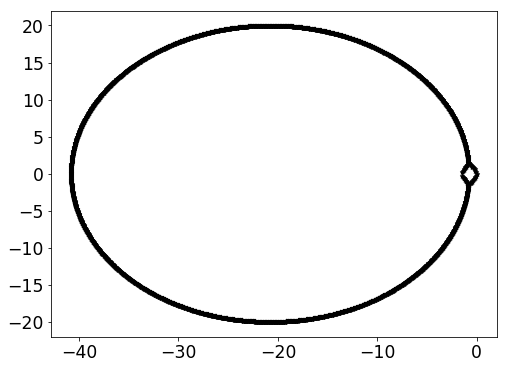

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(eigv.real,eigv.imag,s=20,marker='*',c='k')    

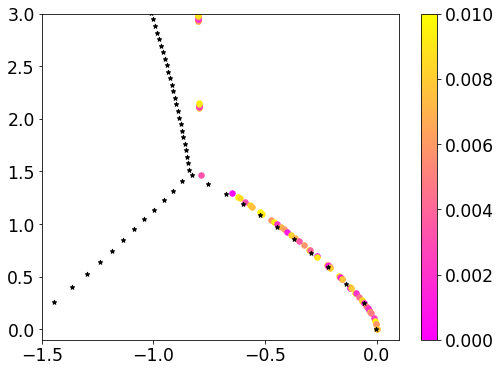

In [37]:
max_=1.01
min_=0.99

cm = plt.cm.get_cmap('RdYlBu')

plt.figure(figsize=(8,6))
for re in range(Grid_size):
    for im in range(Grid_size):
        if (Grid[re,im]>=min_) and (Grid[re,im]<=max_):
            sc=plt.scatter(real_array[re],im_array[im],s=30,c=abs(1-Grid[re,im]), vmin=0, vmax=1-min_, cmap='spring')
            
plt.scatter(eigv.real,eigv.imag,s=20,marker='*',c='k')    
plt.xlim(-1.5,0.1)
plt.ylim(-0.1,3)
plt.colorbar(sc)   

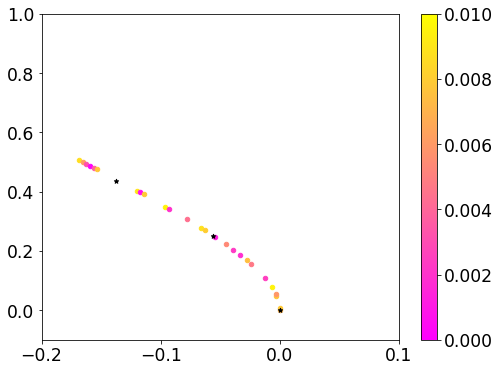

In [38]:
max_=1.01
min_=0.99

cm = plt.cm.get_cmap('RdYlBu')

plt.figure(figsize=(8,6))
for re in range(Grid_size):
    for im in range(Grid_size):
        if (Grid[re,im]>=min_) and (Grid[re,im]<=max_):
            sc=plt.scatter(real_array[re],im_array[im],s=20,c=abs(1-Grid[re,im]), vmin=0, vmax=1-min_, cmap='spring')
plt.scatter(eigv.real,eigv.imag,s=20,marker='*',c='k')    
plt.xlim(-0.2,0.1)
plt.ylim(-0.1,1)
plt.colorbar(sc)    

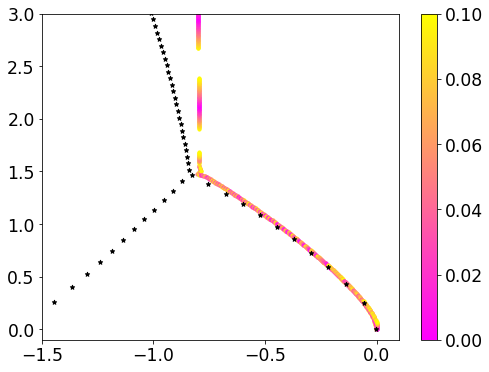

In [41]:
max_=1.1
min_=0.9

cm = plt.cm.get_cmap('RdYlBu')

plt.figure(figsize=(8,6))
for re in range(Grid_size):
    for im in range(Grid_size):
        if (Grid[re,im]>=min_) and (Grid[re,im]<=max_):
            sc=plt.scatter(real_array[re],im_array[im],s=10,c=abs(1-Grid[re,im]), vmin=0, vmax=1-min_, cmap='spring')
            #print(real_array[re])
            
plt.scatter(eigv.real,eigv.imag,s=20,marker='*',c='k')    

plt.xlim(-1.5,0.1)
plt.ylim(-0.1,3)
plt.colorbar(sc)  

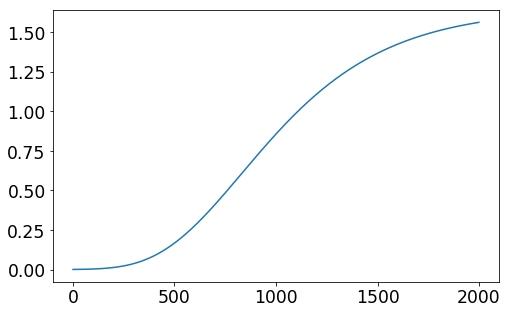

In [12]:
plt.plot(rho)

## look at the activity

In [17]:
t_window=150
dt=0.1
N=int(t_window/dt)

ur=np.zeros((N+1,1))
rho=np.zeros((N,1))

mu_=16
for r in range(N):
    ur[r+1] = ur[r] * (1 - dt / tau)   + mu_*dt / tau
    rho[r] = C * np.exp((ur[r] - U_t) / D)
L=np.zeros((N+1,N+1))
for i in range(N-1):
    L[0,i+1]=rho[i]*dt
    L[i+1,i+1]=-1-rho[i]*dt
    L[i+2,i+1]=1
        
L[0,0]=-1
L[1,0]=1
L[0,N]=1
L[N,N]=-1
    




In [18]:
eigv, vec = np.linalg.eig(L)
eigv=eigv/dt
arr_idx = np.argsort(eigv.real)

for i in range(int((len(arr_idx))/2)): 
    
    if eigv[arr_idx[::-1][2*i+1]].imag<0 :
        
        first=1*arr_idx[::-1][2*i+1]
        second=1*arr_idx[::-1][2*i+2]
        
        arr_idx[::-1][2*i+1]=second
        arr_idx[::-1][2*i+2]=first
        
            
eigv = eigv[arr_idx[::-1]]
vec = vec[:,arr_idx[::-1]]



In [19]:
Lt=np.matrix.getH(L)
eigvt, vect = np.linalg.eig(Lt)
eigvt=eigvt/dt
arr_idxt = np.argsort(eigvt.real)

for i in range(int((len(arr_idxt))/2)): 
    
    if eigvt[arr_idxt[::-1][2*i+1]].imag<0 :
        
        first=1*arr_idxt[::-1][2*i+1]
        second=1*arr_idxt[::-1][2*i+2]
        
        arr_idxt[::-1][2*i+1]=second
        arr_idxt[::-1][2*i+2]=first
        
            
eigvt = eigvt[arr_idxt[::-1]]
vect = vect[:,arr_idxt[::-1]]



In [12]:
for i in range(8):
    print(eigv[i],eigvt[i])

(-7.22942252001e-14+0j) (1.83780221843e-14+0j)
(-0.0570464431121+0.249637951773j) (-0.0570464431121+0.249637951773j)
(-0.0570464431121-0.249637951773j) (-0.0570464431121-0.249637951773j)
(-0.13978211+0.432089710949j) (-0.13978211+0.432089710949j)
(-0.13978211-0.432089710949j) (-0.13978211-0.432089710949j)
(-0.220712628628+0.58491194821j) (-0.220712628628+0.58491194821j)
(-0.220712628628-0.58491194821j) (-0.220712628628-0.58491194821j)
(-0.300306436837+0.720333257014j) (-0.300306436837+0.720333257014j)


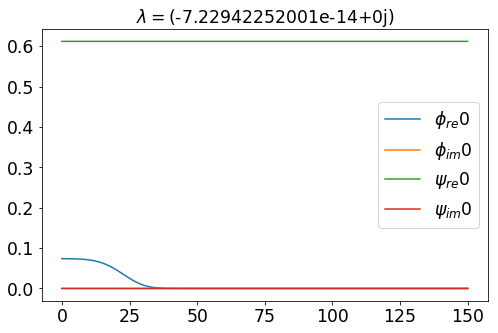

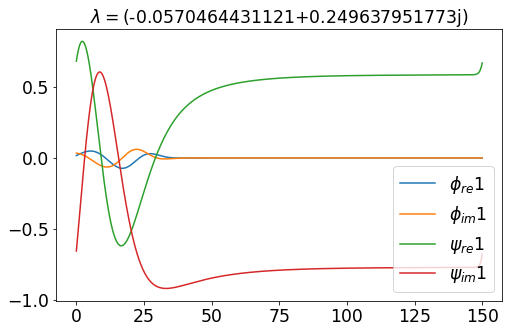

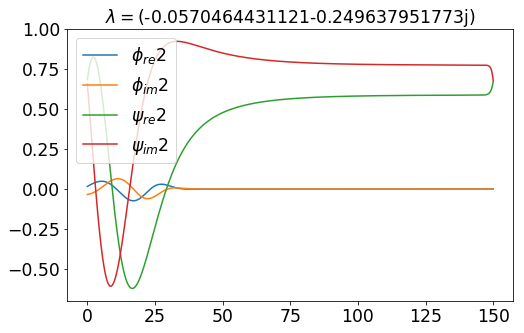

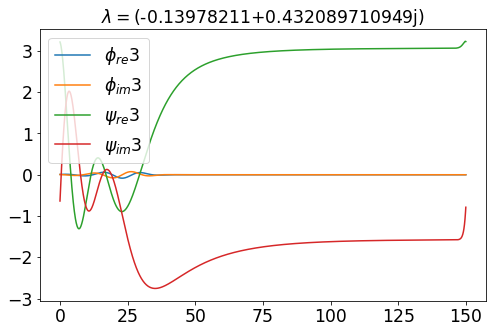

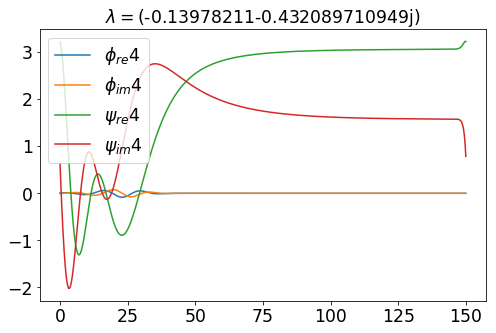

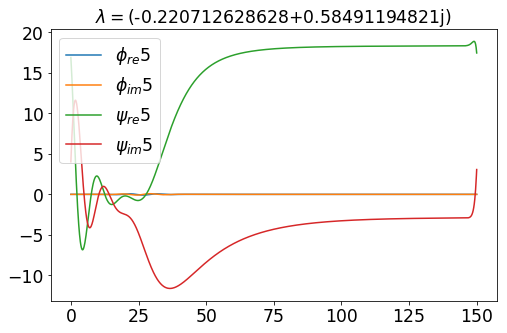

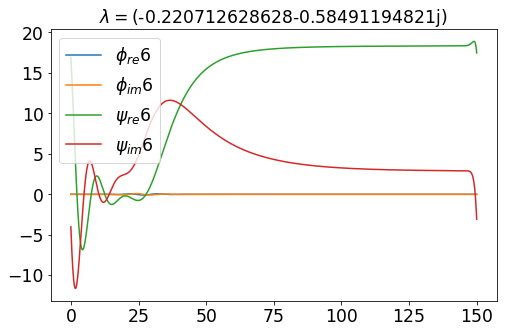

In [20]:
n_first=7

lambda_list=[]
qn0=[]
an0=[]

q_initial=np.zeros((N+1,1))
q_initial[0]=1

t_=[j*dt for j in range(N+1)]


for idx in range(n_first):
    
    lambda_list.append(eigv[idx])
    phi=1*vec[:,idx]
    psi=1*vect[:,idx]
        
    
    
    if i==0:
        norm=abs(np.sum(vec[:,idx].real)*dt)
        phi=phi/norm
            
    if phi[0].real<0:
        phi=phi*(-1)
        
        
    normt=phi.dot(psi)*dt
    psi=psi/normt
        
    
    plt.figure()
    plt.title('$\lambda=$'+str(eigv[idx]))
    plt.plot(t_,phi.real,label='$\phi_{re}$'+str(idx))
    plt.plot(t_,phi.imag,label='$\phi_{im}$'+str(idx))
    plt.plot(t_,psi.real,label='$\psi_{re}$'+str(idx))
    plt.plot(t_,psi.imag,label='$\psi_{im}$'+str(idx))
    plt.legend() 
        
    qn0.append(phi[0])
    an0.append(psi.dot(q_initial))
    
   
t_final=200
N_sim=int(t_final/dt)
time=[i*dt for i in range(N_sim)]

         
nu=np.zeros((N_sim,len(qn0)+1))
for i in range(N_sim):
    t=i*dt
    for n in range(len(qn0)):
        nu[i,n+1]= nu[i,n]+(np.exp(t*lambda_list[n])*qn0[n]*an0[n]).real
        
        


In [21]:
pkl_file = open('from_density_equation.pkl', 'rb')
density = pickle.load(pkl_file)
pkl_file.close()

A=density['A']
t_A=density['t_A']


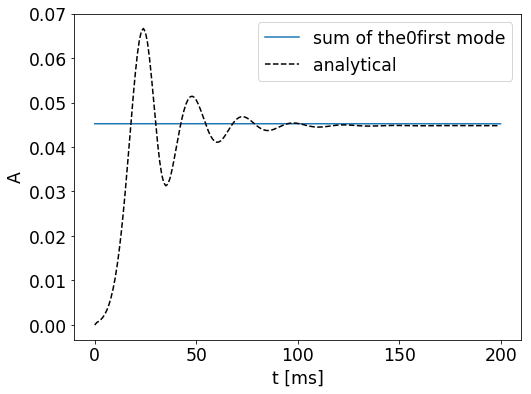

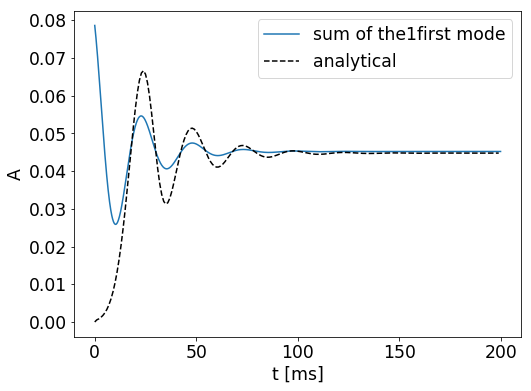

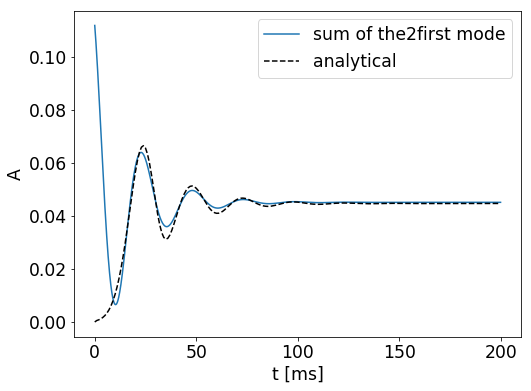

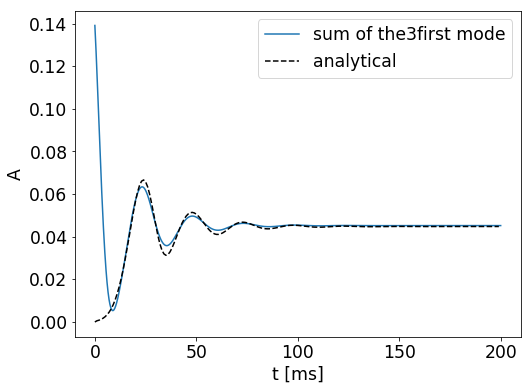

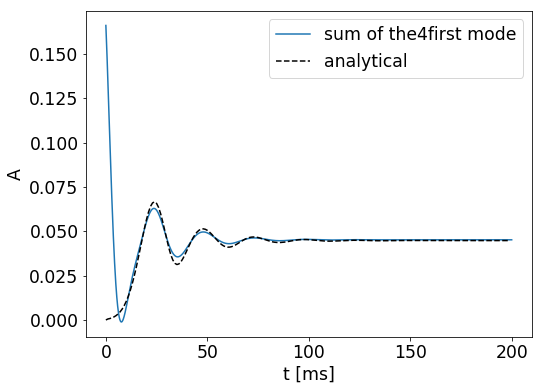

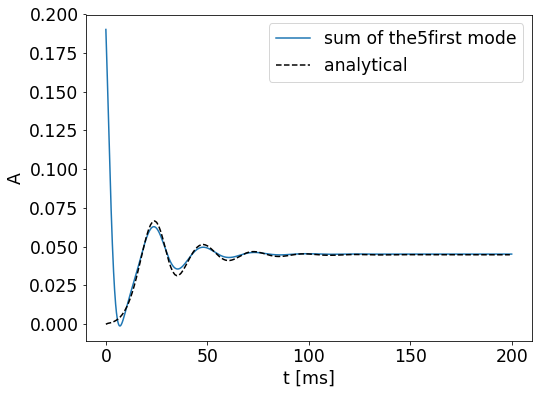

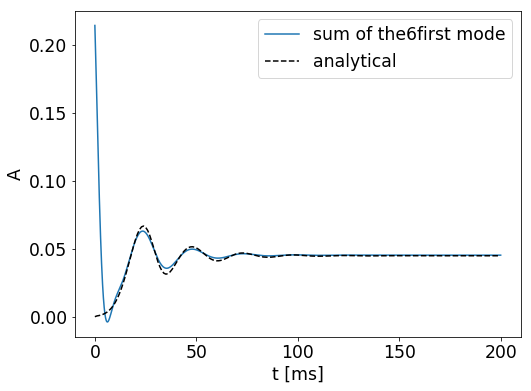

In [15]:
time=[i*dt for i in range(N_sim)]
plt.figure(figsize=(8,6))

for i in range(len(qn0)):
    plt.figure(figsize=(8,6))
    plt.plot(time,nu[:,i+1], label='sum of the' +str(i)+'first mode')
    plt.plot(t_A,A,c='k',ls='--',label='analytical')
    plt.xlabel('t [ms]')
    plt.ylabel('A')
    plt.legend()

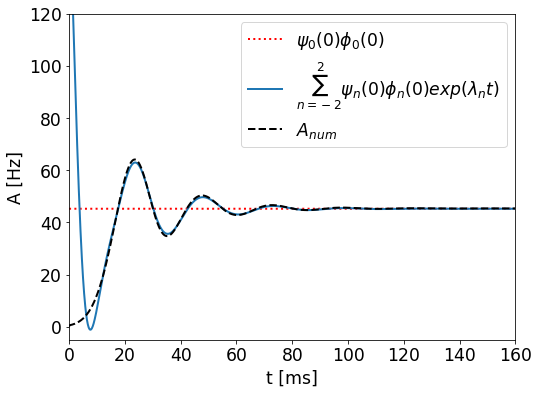

In [22]:
time=[i*dt for i in range(N_sim)]
plt.figure(figsize=(8,6))
plt.plot(time,1000*nu[:,1], label='$\psi_0(0)\phi_0(0)$',c='r',ls=':',lw=2)
plt.plot(time,1000*nu[:,5], label='$\sum_{n=-2}^2\psi_n(0)\phi_n(0)exp(\lambda_nt)$',lw=2)
plt.plot(t_A,1000*A,label='$A_{num}$',ls='--',c='k',lw=2)
plt.xlabel('t [ms]')
plt.ylabel('A [Hz]')
plt.legend()
plt.xlim(0,160)
plt.ylim(-5,120)
plt.savefig('Amodefirst.pdf')

In [23]:
phi=1*vec[:,0]

norm=abs(np.sum(phi.real)*dt)
phi=phi/norm

if phi[0].real<0:
    phi=phi*(-1)



pkl_file = open('from_density_equation.pkl', 'rb')
density = pickle.load(pkl_file)
pkl_file.close()
q=density['q']
t_q=density['t_q']

/Users/gallo/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


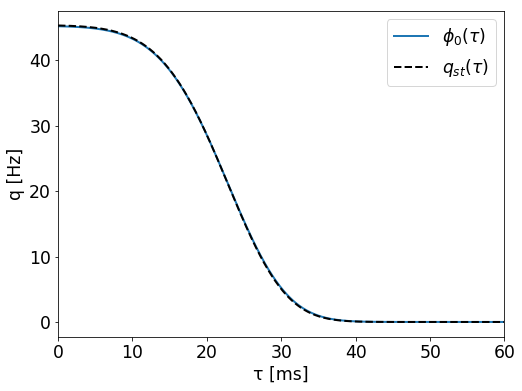

In [24]:
plt.figure(figsize=(8,6))
plt.plot(t_,phi*1000, label='$\phi_0(τ)$',lw=2)
plt.plot(t_q,q[:,-1]*10000,label='$q_{st}(τ)$',ls='--',c='k',lw=2)
plt.xlabel('τ [ms]')
plt.ylabel('q [Hz]')
plt.legend()
plt.xlim(0,60)
plt.savefig('qfirst_st.pdf')
